# 43-wav-embedding-audio-segmented
> Generating embeddings for all allowed audio files

In this notebook, build a dataframe with embeddings from all of the audio files that we manually provided timestamps for.

In [ ]:
#all_no_test

In [ ]:
# modeling packages
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2Model
import soundfile as sf
import torch
import librosa
import warnings
import difflib

# data science packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.plot
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
import seaborn as sns

# other python packages
import os.path
import glob
import re
import math

# Dimension reduction and clustering libraries
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Set preliminaries
Here, we define the base filepath and look at some of the audio files that we have.

In [ ]:
# base file path on accre
base_prefix = '/data/p_dsi/wise/data/'
embeddings_file_prefix = base_prefix + 'embedding_parquet/'

sampling_rate = 16000

# read all parquet files
embeds_dfs_list = glob.glob(embeddings_file_prefix + '*.parquet')
print(len(embeds_dfs_list))

11


# Load all data files
Now, we'll load all data files as parquet files and make one huge dataframe for processing.

In [ ]:
#read in all files as a list
embeds_dfs = [pd.read_parquet(embed_file, columns=['id', 'label', 'last_hidden_state_mean'])
              for embed_file in embeds_dfs_list]

In [ ]:
#make one giant dataframe
final_pd = pd.concat(embeds_dfs)
display(final_pd.head())
final_pd.shape

,id,label,last_hidden_state_mean
0,083-2,NEU,"[-0.011404458433389664, -4.232761784805916e-05..."
1,083-2,OTR,"[-0.018522022292017937, -0.026032166555523872,..."
2,083-2,NEU,"[0.03853766247630119, -0.017163043841719627, -..."
3,083-2,OTR,"[0.01437150128185749, 0.006724287755787373, -0..."
4,083-2,OTR,"[-0.06663864105939865, 0.07268811762332916, 0...."


(1954, 3)

In [ ]:
final_pd['label'].value_counts()

NEU    848
OTR    709
PRS    270
REP    127
Name: label, dtype: int64

# Explore unsupervised clustering of embeddings
We'll start by generating the data into the correct format.

In [ ]:
dat = np.array(final_pd['last_hidden_state_mean'].tolist())
dat.shape

(1954, 768)

### Default parameters for umap colored by four labels

<Figure size 720x360 with 0 Axes>

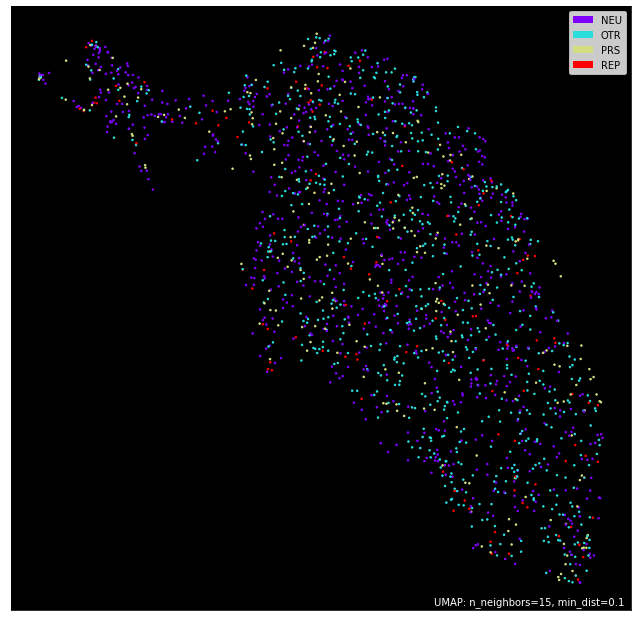

In [ ]:
mapper = umap.UMAP().fit(dat)
plt.figure(figsize=(10, 5));
umap.plot.points(mapper, labels = final_pd['label'], theme='fire');

### Default parameters for umap colored by different speakers

<Figure size 720x360 with 0 Axes>

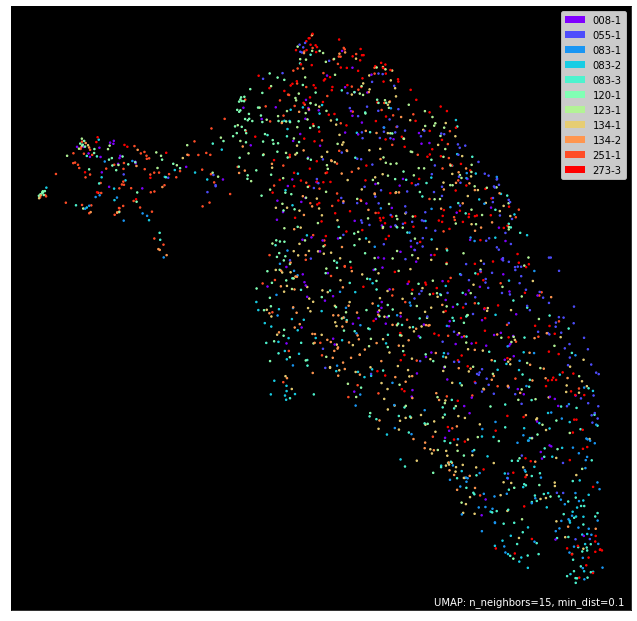

In [ ]:
mapper = umap.UMAP().fit(dat)
plt.figure(figsize=(10, 5));
umap.plot.points(mapper, labels = final_pd['id'], theme='fire');

## Try umap supervised learning to reduce our dimension
### Encode all labels and id into number for clusters

In [ ]:
#We'll start with giving labels
classes = ['NEU', 'PRS', 'REP', 'OTR']
label2id = {lab:ind for ind, lab in enumerate(classes)}
label2id

{'NEU': 0, 'PRS': 1, 'REP': 2, 'OTR': 3}

In [ ]:
#Get IDs encoding
ids_list = ['134-1', '055-1', '083-2', '273-3', '120-1', '083-3', '251-1', '008-1', '123-1', '134-2', '083-1']
ids2id = {ids:ind for ind, ids in enumerate(ids_list)}

In [ ]:
#get encodings
encoded_label = final_pd['label'].replace(label2id).tolist()
encoded_id = final_pd['id'].replace(ids2id).tolist()
#encoded_id

In [ ]:
%%time
embedding = umap.UMAP().fit_transform(dat, y = encoded_label)

CPU times: user 22.5 s, sys: 573 ms, total: 23.1 s
Wall time: 5.64 s


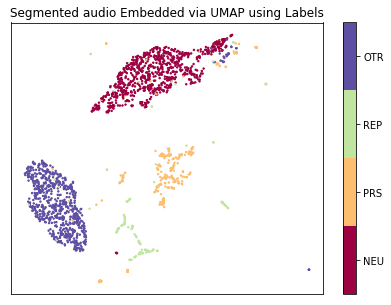

In [ ]:
fig, ax = plt.subplots(1, figsize=(7, 5))
plt.scatter(*embedding.T, s = 2, c = encoded_label, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('Segmented audio Embedded via UMAP using Labels');

## UMAP enhanced clustering

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors = 30,
    min_dist= 0,
    n_components=2,
    random_state=42,
).fit_transform(dat)

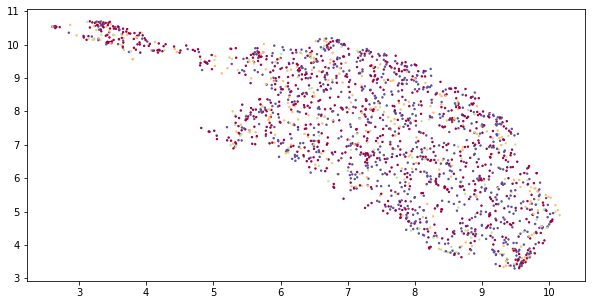

In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c = encoded_label, s=2, cmap='Spectral');

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)
np.unique(labels)

array([-1])

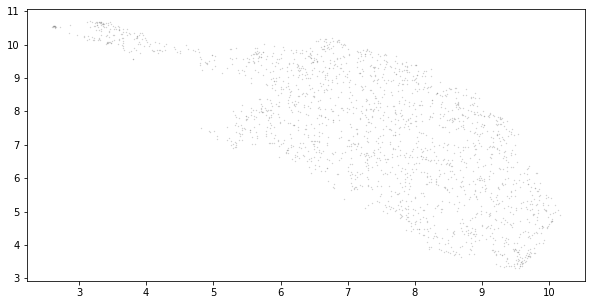

In [ ]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

### UMAP enhanced clustering and HDBSCAN can't cluster it at all, all the data are counted as noise showing gray.

### Define a function to run different parameters (tune the umap model to best separate clusters)

In [ ]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title='', data = dat):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    #u = fit.fit_transform(data);
    u = fit.fit(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=np.arange(data.shape[0]))
    if n_components == 2:
        #ax = fig.add_subplot(111)
        #ax.scatter(u[:,0], u[:,1], c=np.arange(data.shape[0]))
        umap.plot.points(u, labels = final_pd['label'], theme='fire')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=np.arange(data.shape[0]), s=100)
    plt.title(title, fontsize=18)

### Try different number of neighbors

/data/p_dsi/wise/env/lib/python3.9/site-packages/umap/spectral.py:255: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


<Figure size 720x360 with 0 Axes>

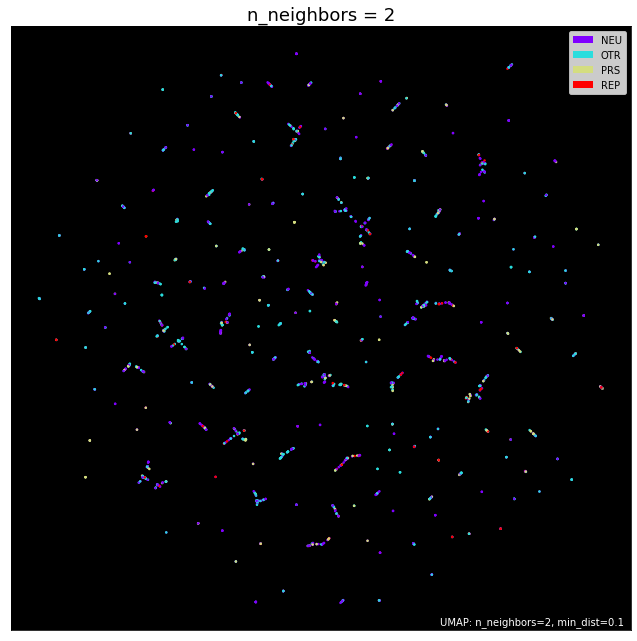

<Figure size 720x360 with 0 Axes>

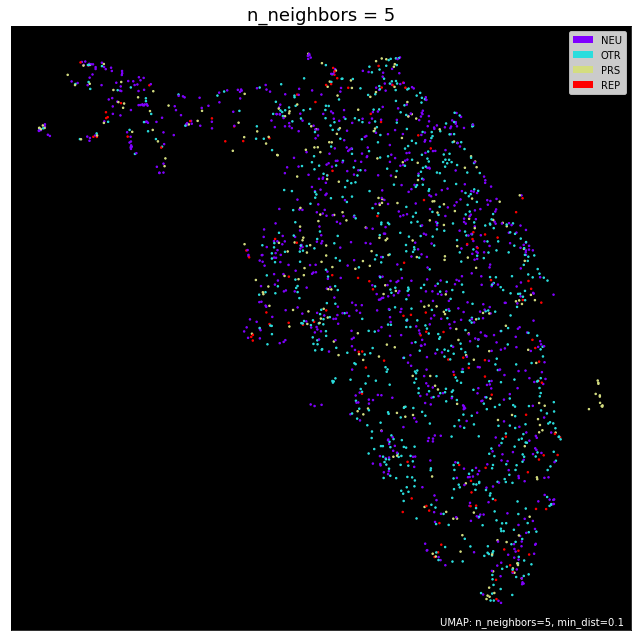

<Figure size 720x360 with 0 Axes>

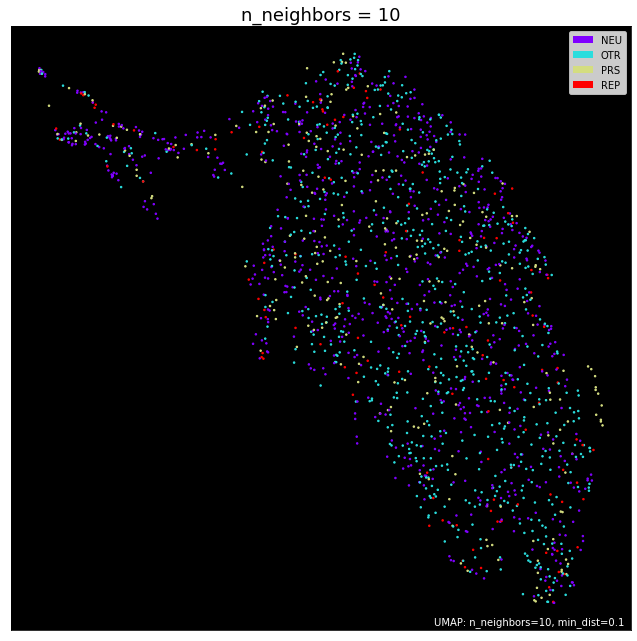

<Figure size 720x360 with 0 Axes>

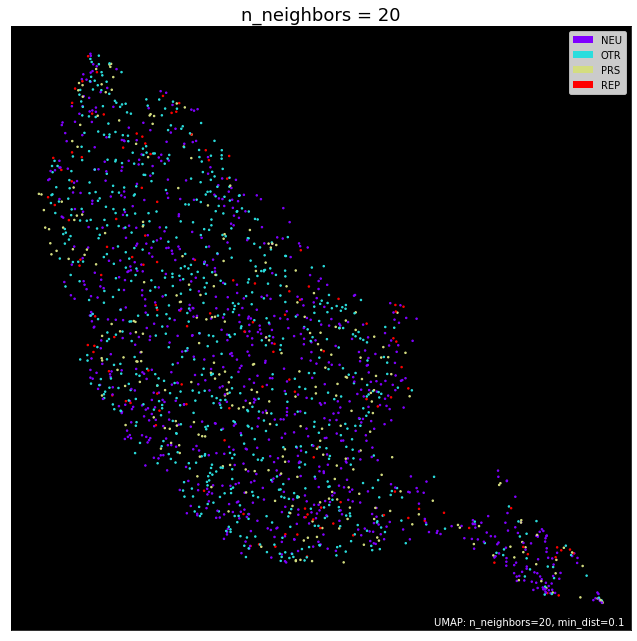

<Figure size 720x360 with 0 Axes>

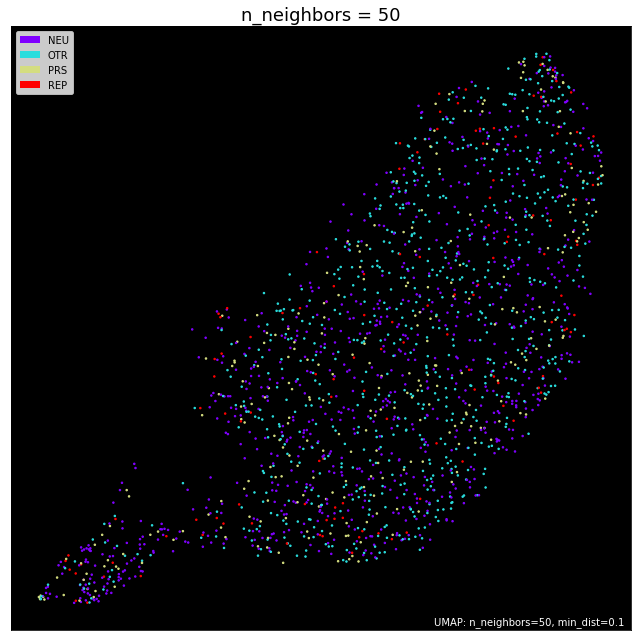

<Figure size 720x360 with 0 Axes>

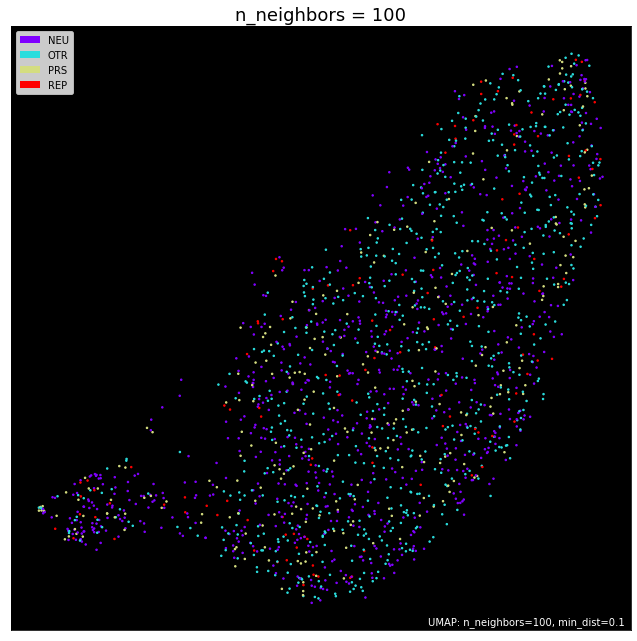

<Figure size 720x360 with 0 Axes>

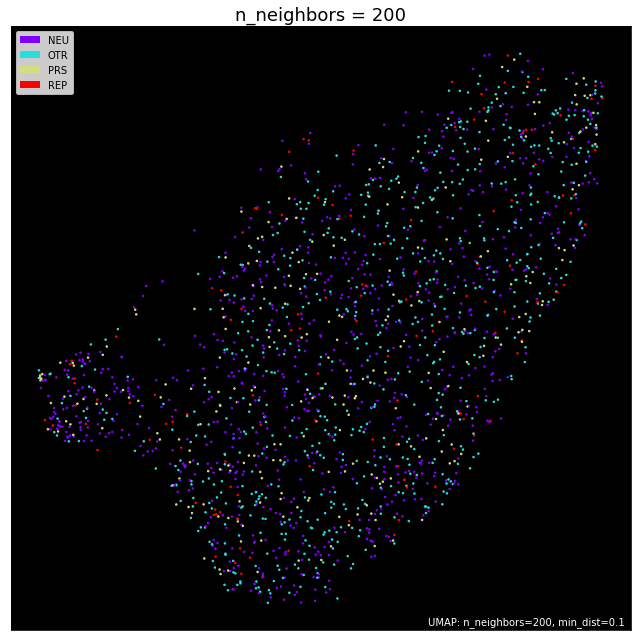

In [ ]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

## Define kmeans tunning function for different number of clusters

In [ ]:
def kmean_hyper_param_tuning(data):
    """
    Hyper parameter tuning to select the best from all the parameters on the basis of silhouette_score.
    :param data: dimensionality reduced data after applying PCA
    :return: best number of clusters for the model (used for KMeans n_clusters)
    """
    # candidate values for our number of cluster
    parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]

    # instantiating ParameterGrid, pass number of clusters as input
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans()     # instantiating KMeans model
    silhouette_scores = []

    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(data)          # fit model on wine dataset, this will find clusters based on parameter p

        ss = metrics.silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores

        print('Parameter:', p, 'Score', ss)

        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # plotting silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()

    return best_grid['n_clusters']

### First use umap to reduce dimension to 2 then run above tune function to choose the best k

Parameter: {'n_clusters': 2} Score 0.45906273
Parameter: {'n_clusters': 3} Score 0.44211978
Parameter: {'n_clusters': 4} Score 0.40306598
Parameter: {'n_clusters': 5} Score 0.44199455
Parameter: {'n_clusters': 10} Score 0.3983891
Parameter: {'n_clusters': 15} Score 0.39496124
Parameter: {'n_clusters': 20} Score 0.3818492
Parameter: {'n_clusters': 25} Score 0.38633767
Parameter: {'n_clusters': 30} Score 0.385408
Parameter: {'n_clusters': 35} Score 0.37530512
Parameter: {'n_clusters': 40} Score 0.37416607


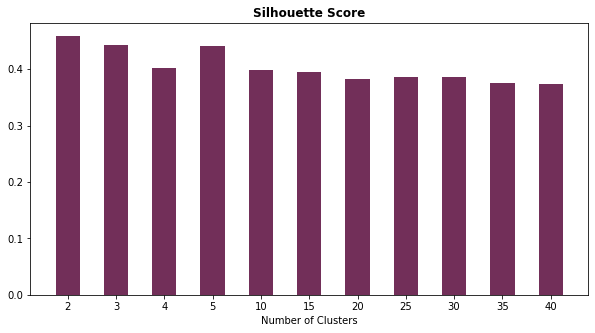

2

In [ ]:
kmean_hyper_param_tuning(umap.UMAP().fit_transform(dat))

### The best k is 2, so we used 2 clusters currently

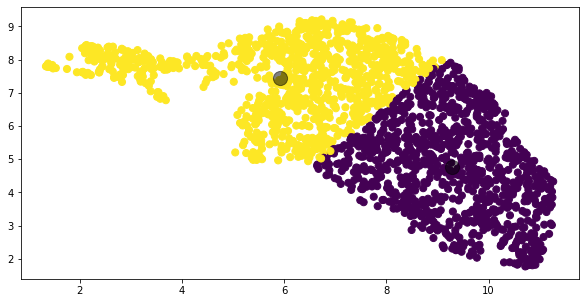

In [ ]:
X = umap.UMAP().fit_transform(dat)
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Training with Labels and Embedding Unlabelled Test Data
## (Metric Learning with UMAP)

To try this out with UMAP let’s use the train/test split provided by StratifiedShuffleSplit

In [ ]:
y = np.array(encoded_label)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(dat, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dat[train_index], dat[test_index]
    y_train, y_test = y[train_index], y[test_index]

Now we can fit a model to the training data, making use of the training labels to learn a supervised embedding.

UMAP has several hyperparameters that can have a significant impact on the resulting embedding. In this notebook we will be covering the four major ones:
1. n_neighbors
2. min_dist
3. n_components
4. metric

In [ ]:
%%time
mapper = umap.UMAP(n_neighbors=50, min_dist= 0.06, n_components=2, metric='euclidean').fit(X_train, np.array(y_train))

CPU times: user 23 s, sys: 598 ms, total: 23.6 s
Wall time: 4.54 s


Next we can use the `transform()` method on that model to transform the test set into the learned space. This time we won’t pass the label information and let the model attempt to place the data correctly.

In [ ]:
%%time
test_embedding = mapper.transform(X_test)

CPU times: user 11.3 s, sys: 278 ms, total: 11.6 s
Wall time: 9.52 s


The important question is how well we managed to embed the test data into the existing learned space. To start let’s visualise the embedding of the training data so we can get a sense of where things should go.

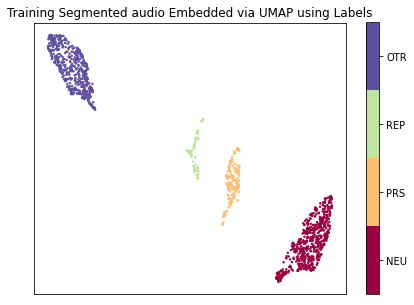

In [ ]:
fig, ax = plt.subplots(1, figsize=(7, 5))
plt.scatter(*mapper.embedding_.T, s = 2, c = np.array(y_train), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('Training Segmented audio Embedded via UMAP using Labels');

As you can see this has done a similar job as before, successfully embedding the separate classes while retaining both the internal structure and the overall global structure. However, one class, Praise, is more sparse than the previous one; Neural and OTR are well separated meanwhile Reprimand is still spread out all canvas. We can now look at how the test set, for which we provided no label information, was embedded via the transform() method.

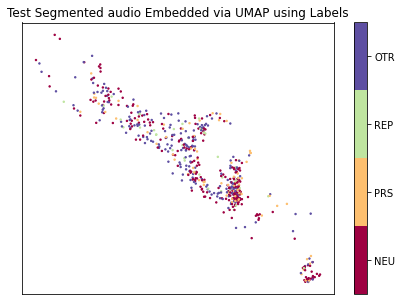

In [ ]:
fig, ax = plt.subplots(1, figsize=(7, 5))
plt.scatter(*test_embedding.T, s = 2, c = np.array(y_test), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title('Test Segmented audio Embedded via UMAP using Labels');